**Problem description**

In this problem, we want to categorize 10-CIFAR datasets. This database is a smaller version of the 100-CIFAR database, which is limited to images from 10 different categories. You can see the category of images of this database in the figure below.
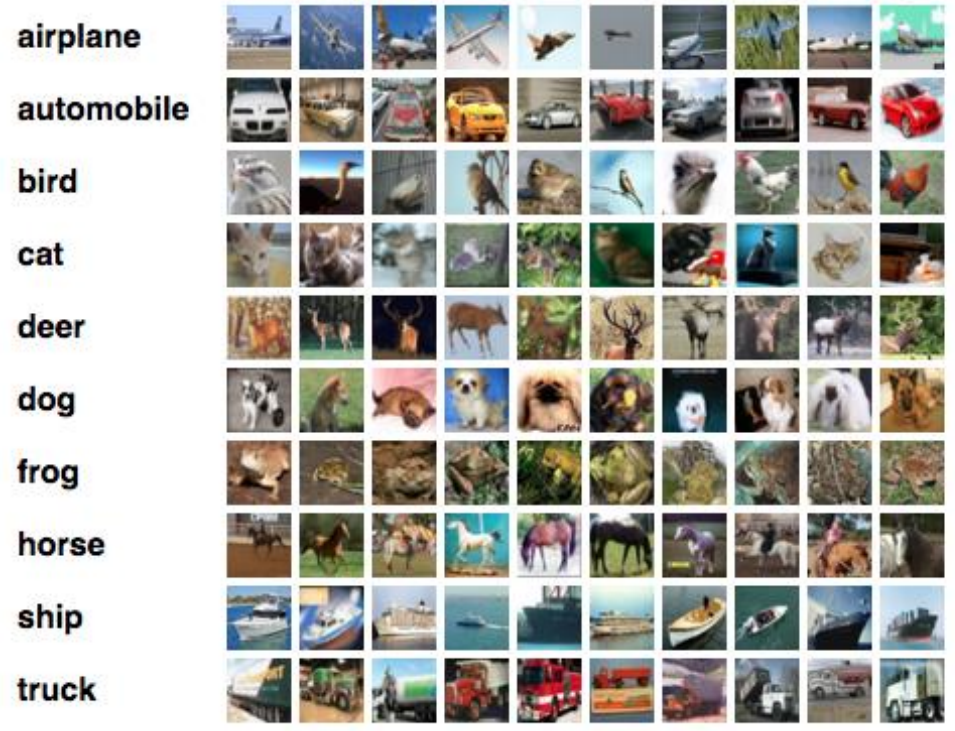

Here, to reduce the computational volume, we use only the images of the first 4 classes of this dataset. As a result, our output layer will contain 4 neurons. The neuron with the highest amount of activation is selected as the category detected by our model. For this neural network, we consider two hidden layers, each with 16 neurons.
So the structure of our neural network will be as follows:
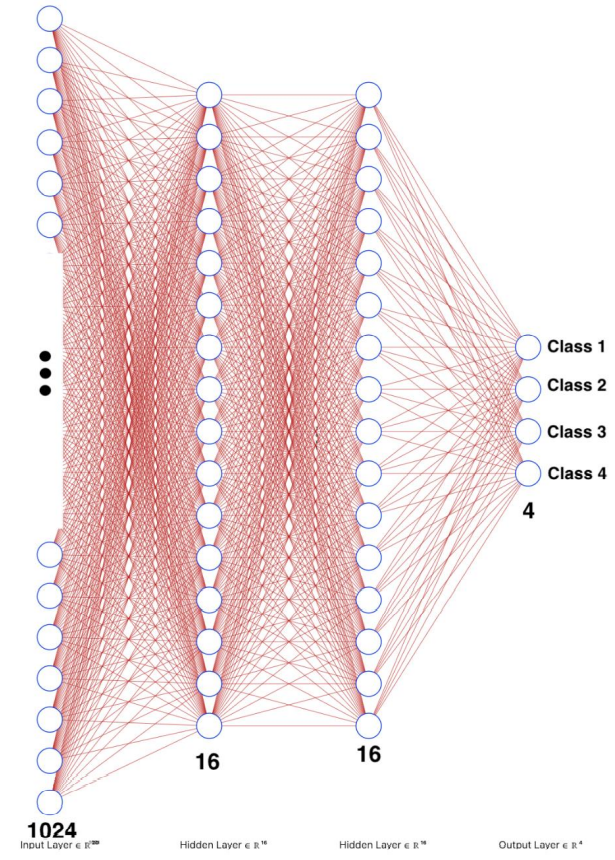

The pseudocode of our neural network learning process is the Descent Gradient Stochastic method. The idea of this method is that instead of training with the whole set of data at each stage of model learning, we can split the data into sections called "batch-mini" at each step, with a gradient for each sample. Get that batch-mini, and finally get their average and then apply the changes. This reduces computations per scan and speeds up convergence.

**Step 1: Get the data, data visualization and preprocessing**

First you need to download the CIFAR10 dataset from this [link](https://drive.google.com/file/d/1Y1vgzPvMeVcXSxDfOlCVia7wsU7p8M6g/view). You can easily download this file using the gdown library, which is installed by default in colab. By entering the following cell in Jupiter, the data collection and extraction operation is done for you.

In [ ]:
!gdown --id 1Y1vgzPvMeVcXSxDfOlCVia7wsU7p8M6g -O CIFAR10.tar.gz
!tar xzf CIFAR10.tar.gz

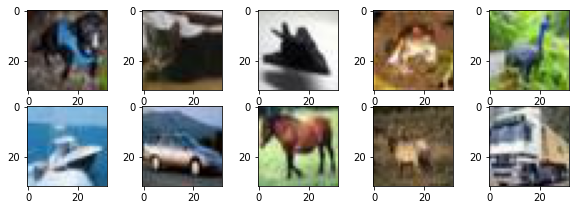

In [53]:
import numpy as np
import matplotlib as mp
import glob
import os
import random
import time

# Plot first picture of each class in train folder
images = []
for img_path in glob.glob('/content/CIFAR10/train/*/0000.jpg'):
    images.append(mp.image.imread(img_path))

mp.pyplot.figure(figsize=(10,5))
columns = 5
for i, image in enumerate(images):
    mp.pyplot.subplot(len(images) / columns + 1, columns, i + 1)
    mp.pyplot.imshow(image)

In both training and test datasets, read the first 4 sets of datasets, including data for airplane, automobile, bird, and cat classes, in a numpy array. Also store the tags of this data in a separate hot-one matrix.
To create a one-hot array here, because we have four classes, we consider four columns for each data, each column represents the corresponding class. We set the corresponding column of the class to which the data belongs to one and the other columns equal to zero.

In [54]:
# َAllocate numpy arrays to store data and lable of training and test sets
data_train = np.zeros((20000, 32, 32, 3))
data_test = np.zeros((4000, 32, 32, 3))
label_train = np.zeros((20000, 4))
label_test = np.zeros((4000, 4))

train_cnt = 0
test_cnt = 0
classes = os.listdir('/content/CIFAR10/train')

# Store images in arrays and build their one-hot label matrix
for i in range(4):
  dir = os.path.join('/content/CIFAR10/train', classes[i])

  # Set train data and label
  for img_path in glob.iglob(f'{dir}/*.jpg'):
    img = mp.image.imread(img_path)
    data_train[train_cnt] = img
    label_train[train_cnt][i] = 1
    train_cnt += 1

  # Set test data and label
  dir = os.path.join('/content/CIFAR10/test', classes[i])
  for img_path in glob.iglob(f'{dir}/*.jpg'):
    img = mp.image.imread(img_path)
    data_test[test_cnt] = img
    label_test[test_cnt][i] = 1
    test_cnt += 1


To reduce the computational complexity, gray the images. If you created the data matrices in the previous step correctly, the following function will convert all your datasets to gray images.

In [55]:
# Convert RGB images to Grayscale
def rgb2gray(rgb):
  r, g, b = rgb[:, :, :, 0], rgb[:, :, :,1], rgb[:, :, :, 2]
  gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
  return gray

data_train_gray = np.zeros((20000, 32, 32))
data_test_gray = np.zeros((4000, 32, 32))

data_train_gray = rgb2gray(data_train)
data_test_gray = rgb2gray(data_test)

'''
# Plot gray image
from PIL import Image
im = Image.fromarray(data_test_gray[0])
mp.pyplot.imshow(im)
'''

# Normalizing data
data_train_gray = np.divide(data_train_gray, 255)
data_test_gray = np.divide(data_test_gray, 255)

# Flating data
data_train_gray = data_train_gray.reshape(-1, 1024)
data_test_gray = data_test_gray.reshape(-1, 1024)

#print(data_train_gray.shape)
#print(data_test_gray.shape)


In [56]:
'''
This function shuffles arrays A and B in the same way
'''
def shuffle_same_order(A, B):
  randomize = np.arange(len(B))

  np.random.shuffle(randomize)

  A = A[randomize]
  B = B[randomize]
  return A, B
  
# Shuffle the data and label sets
data_train_gray, label_train = shuffle_same_order(data_train_gray, label_train)
data_test_gray, label_tets = shuffle_same_order(data_test_gray, label_test)

**Step 2: Feedforward**

To calculate the output from the input in neural networks, the following operations are performed in each layer:
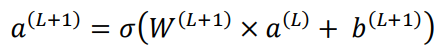

Therefore, for weight and biases between layers we assign matrix. Weigth matrixes are shown with W_k, where k is the number of layer, and biases with b_k.

In [57]:
# Definition of sigmoid function
def sigmoid(x):
  return 1/(1 + np.exp(-x))

In [58]:
input_neuron = 1024
hidden1_neuron = 16
hidden2_neuron = 16
output_neuron = 4

def initialize_W():
  W1 = np.random.normal(0, 1, size=(hidden1_neuron, input_neuron))
  W2 = np.random.normal(0, 1, size=(hidden2_neuron, hidden1_neuron))
  W3 = np.random.normal(0, 1, size=(output_neuron, hidden2_neuron))
  return W1, W2, W3

def initialize_b():
  b1 = np.zeros((hidden1_neuron, 1))
  b2 = np.zeros((hidden2_neuron, 1))
  b3 = np.zeros((output_neuron, 1))
  return b1, b2, b3

'''
This function is to feedforward. 
It's inputs are the input data and the weights and biases.
The output of this function is the Zi's and Ai's where:
A0 = input
Zi = Wi * A(i-1) + bi
Ai = sigmoid(Zi)
'''
def feedforward(x, W1, W2, W3, b1, b2, b3):
    # As x.shape is (1024,) we reshape it to (1024,1)
    Z1 = np.dot(W1,x.reshape(-1,1)) + b1
    A1 = sigmoid(Z1)

    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)

    Z3 = np.dot(W3, A2) + b3
    output = sigmoid(Z3)

    return Z1,Z2,Z3,A1,A2,output

'''
This function calculates the accuracy of obtained output.
To do so, it gains the output by calling feedforward.
The output is a (4,1) array. The answer is the index of the maximum element in it.
So if the index of the obtained output is the same as original answer, then the answer is accurate.
Here we calculate the accurate percentage of the answer.
'''
def accuracy_calc(X, Y, W1, W2, W3, b1, b2, b3):
  true = 0

  for x,y in zip(X,Y):
    Z1,Z2,Z3,A1,A2,output = feedforward(x, W1, W2, W3, b1, b2, b3)
    # Obtain the calculated output index
    obtained_ans = list(output).index(max(output))

    # Obtain the original output index
    original_ans = list(y).index(1)
    
    # Check whether the answer is true or not
    if obtained_ans == original_ans:
      true += 1
  accuracy = (true/len(X)) * 100
  return accuracy


After initializing weights and biases and defining sigmoid function, we seperate first 200 images of our train dataset, and then calculate the output based in the formula.

For calculating the accuracy of our model, we compare the calculated output with label. We expect a mean of 25% accuracy because we assigned weight randomly and we have 4 different labels.

In [59]:
X = data_train_gray[:200]
Y = label_train[:200]

# Initialize W and bias matrixes
W1, W2, W3 = initialize_W()
b1, b2, b3 = initialize_b()

accuracy = accuracy_calc(X, Y, W1, W2, W3, b1, b2, b3)
print('Accuracy before training is ' + str(accuracy) + '%')

Accuracy before training is 22.0%


**Step 3: Backpropagation with for loop**

One of our main goals during the learning process is to minimize the cost function.

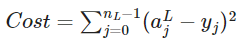

In order to minimize the cost function, we use gradient descent, that means taking partial derivative of cost function for all variables.

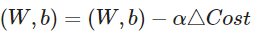

We take derivatives with help of backpropagation.


In [60]:
# Compute SSE cost
def cost_function(y_star, y):
  return ((y_star - y)**2).sum()

# Derivation of sigmoid
def sigmoid_deriv(a):
  return a * (1 - a)

Consider following definitions:

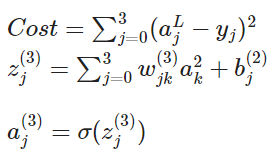

For weight and bias we apply derivative chain rule.


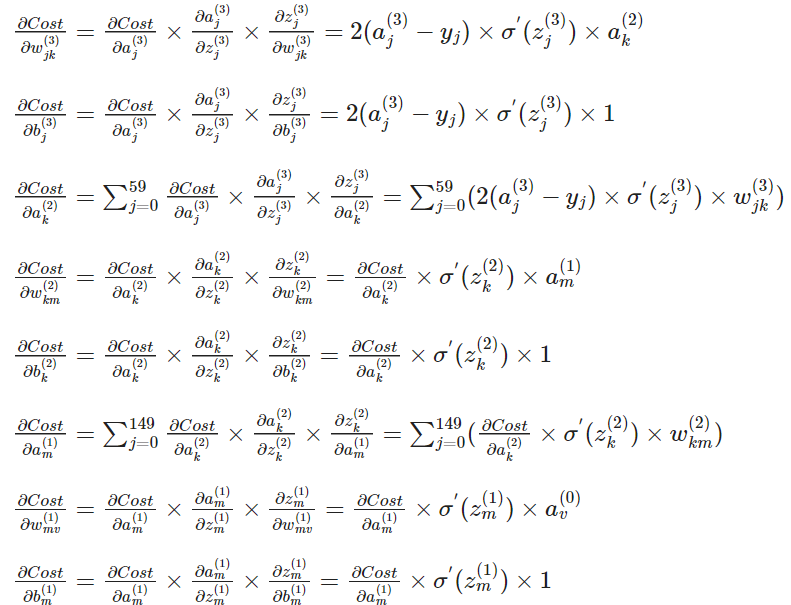

But why do we get the cost derivative with respect to a's, when it is not one of our function parameters and we can not change it directly? This is because these derivatives are used to calculate the cost derivative relative to the W and b's of the previous layer.

**Backpropagation implementation**

In [66]:
def backpropagation(Z1, Z2, Z3, a0, a1, a2, a3, Y, input_n, output_n, hidden1_n, hidden2_n):
  # Initialize arrays for gradients to zero
  grad_W1 = np.zeros((hidden1_n, input_n))
  grad_W2 = np.zeros((hidden2_n, hidden1_n))
  grad_W3 = np.zeros((output_n, hidden2_n))

  grad_b1 = np.zeros((hidden1_n, 1))
  grad_b2 = np.zeros((hidden2_n, 1))
  grad_b3 = np.zeros((output_n, 1))

  grad_a2 = np.zeros((hidden2_n, 1))
  grad_a1 = np.zeros((hidden1_n, 1))

  # Calculate backpropagation algorithm using "for loop"
  for j in range(4):
    for k in range(16):
      grad_W3[j][k] += a2[k][0] * sigmoid_deriv(a3[j][0]) * (2 * a3[j][0]- 2 * Y[j]) 
        
  for j in range(4):
    grad_b3[j][0] += sigmoid_deriv(a3[j][0]) * (2 * a3[j][0]- 2 * Y[j]) 
        
  for k in range(16):
    for j in range(4):
      grad_a2[k][0] += W3[j][k] * sigmoid_deriv(a3[j][0]) * (2 * a3[j][0]- 2 * Y[j])
                
  for k in range(16):
    for m in range(16):
      grad_W2[k][m] += a1[m][0] * sigmoid_deriv(a2[k][0]) * grad_a2[k][0]
                  
  for k in range(16):
    grad_b2[k][0] += sigmoid_deriv(a2[k][0]) * grad_a2[k][0]
            
  for m in range(16):
    for k in range(16):
      grad_a1[m][0] += W2[k][m] * sigmoid_deriv(a2[k][0]) * grad_a2[k][0]
                
  for m in range(16):
    for v in range(1024):
      grad_W1[m][v] += a0[v] * sigmoid_deriv(a1[m][0]) * grad_a1[m][0]
              
  for m in range(16):
    grad_b1[m][0] += sigmoid_deriv(a1[m][0]) * grad_a1[m][0]

  # Pack the gradients to return from function
  grad_W = {}
  grad_W[0] = grad_W1
  grad_W[1] = grad_W2
  grad_W[2] = grad_W3

  grad_b = {}
  grad_b[0] = grad_b1
  grad_b[1] = grad_b2
  grad_b[2] = grad_b3

  return grad_W,grad_b

'''
After calculating gradient of weights, we update them.
This functions divides dataset to batches and updates the weights.
For each epoch, it calculates the cost using the above formula.
Finally returns trained weights and costs.
'''
def train(data, label, epoch_num, batch_size, learning_rate, input_n, 
          output_n, hidden1_n, hidden2_n):
  W1, W2, W3 = initialize_W()
  b1, b2, b3 = initialize_b()
  costs = []

  for i in range(epoch_num):
    # Shuffle data and labels to start the algorithm
    data_train_gray, label_train = shuffle_same_order(data, label)
    cost = 0
    for n in range(len(data)//batch_size):
      # In each batch we have data and corresponding labels
      batch1 = data[n * batch_size: (n+1) * batch_size]
      batch2 = label[n * batch_size: (n+1) * batch_size]   

      # Initialize arrays for gradient of weights and biases
      grad_W1 = np.zeros((hidden1_n, input_n))
      grad_W2 = np.zeros((hidden2_n, hidden1_n))
      grad_W3 = np.zeros((output_n, hidden2_n))
      grad_b1 = np.zeros((hidden1_n, 1))
      grad_b2 = np.zeros((hidden2_n, 1))
      grad_b3 = np.zeros((output_n, 1))
              
      # Iterate over data in tch
      for X, Y in zip(batch1, batch2):
        # a0 = input
        a0 = X
        Z1,Z2,Z3,a1,a2,a3 = feedforward(X, W1, W2, W3, b1, b2, b3)
        # Get gradients from backpropagation
        grad_W,grad_b = backpropagation(Z1,Z2,Z3,a0,a1,a2,a3,Y,input_n,output_n, hidden1_n, hidden2_n)
        
        # a3 = output
        cost += cost_function(Y, a3)

        # Update gradients of weights and biases
        grad_W1 += grad_W[0]
        grad_W2 += grad_W[1]
        grad_W3 += grad_W[2]
        grad_b1 += grad_b[0]
        grad_b2 += grad_b[1]
        grad_b3 += grad_b[2]

      # Update value of wights and biases using gradient descent
      W1 = W1 - learning_rate * (grad_W1 / batch_size)
      W2 = W2 - learning_rate * (grad_W2 / batch_size)
      W3 = W3 - learning_rate * (grad_W3 / batch_size)
      b1 = b1 - learning_rate * (grad_b1 / batch_size)
      b2 = b2 - learning_rate * (grad_b2 / batch_size)
      b3 = b3 - learning_rate * (grad_b3 / batch_size)
        
    costs.append(cost/len(data))
  return W1,W2,W3,b1,b2,b3,costs


Now we train the weights and biases using 200 samples of train data. Number of epochs is 15, batch size is 16 and learning rate is 0.3. (In the problem we are asked to train for 10 epochs but as the time is reasonable, we increased the number of epochs to 15.)

Due to the small number of epochs and training data, it is expected that at the end of the learning process, the accuracy of the model in this case will be about 30% on average.

Runtime is 144.42557668685913 seconds


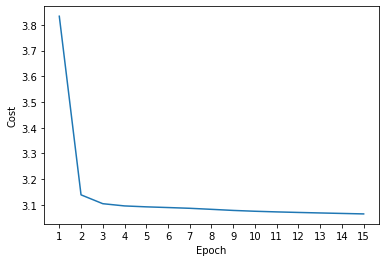

Accuracy after training on train data is: 28.999999999999996%
Accuracy after training on test data is: 35.0%


In [62]:
num_of_epochs = 15
batch_size = 16
learning_rate = 0.3

start = time.time()

X = data_train_gray[:200]
Y = label_train[:200]
W1_t,W2_t,W3_t,b1_t,b2_t,b3_t,costs = train(X, Y, num_of_epochs, batch_size,
                                            learning_rate, 1024, 4, 16, 16)
end = time.time()
print(f"Runtime is {end - start} seconds")

mp.pyplot.plot(costs)
mp.pyplot.xticks(np.arange(len(costs)), np.arange(1, len(costs)+1))
mp.pyplot.xlabel("Epoch")
mp.pyplot.ylabel("Cost")
mp.pyplot.show()

accuracy = accuracy_calc(X, Y, W1_t, W2_t, W3_t, b1_t, b2_t, b3_t)
print('Accuracy after training on train data is: ' + str(accuracy) + "%")

X_test = data_test_gray[:200]
Y_test = label_test[:200]

accuracy = accuracy_calc(X_test, Y_test, W1_t, W2_t, W3_t, b1_t, b2_t, b3_t)
print('Accuracy after training on test data is: ' + str(accuracy) + "%")

**Step 4: Vectorization**

So far we have only worked with the first 200 datasets because the current training process is too long and not optimal for network learning. To solve this problem, we use a concept called vectorization. This concept means that instead of using "for" on the drives, we implement the operation in the form of a matrix operation.

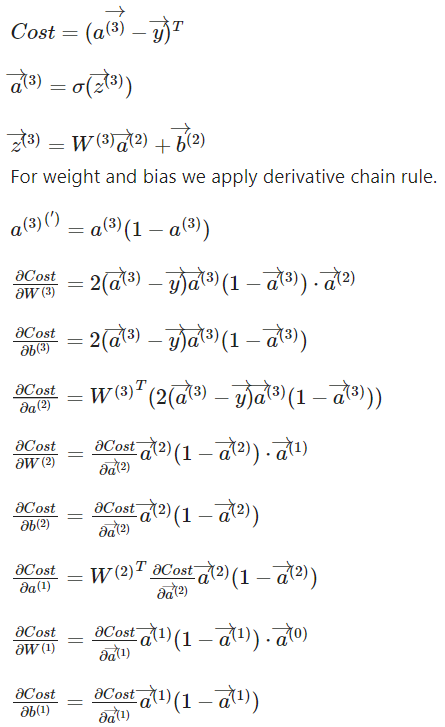

This reduces code execution time significantly. The main reason for this acceleration in computations is that matrix operations can be well parallelized and performed in multicore. Processors also have instructions for working with big data and vectors that run more efficiently.

In [70]:
'''
This function calculates the gradients of weights and biases as "backpropagation" function.
The difference between this function and the previous one is that this function acts as a matrix with a gradient of weights.
So instead of using "for" to calculate gradients, we use matrix operations here.
The output of this function is the gradient of weights and biases.
'''
def backpropagation_vectorized(Z1, Z2, Z3, a0, a1, a2, a3, Y, input_n, output_n, 
                               hidden1_n, hidden2_n):
  # Initialize arrays for gradients to zero
  grad_W1 = np.zeros((hidden1_n, input_n))
  grad_W2 = np.zeros((hidden2_n, hidden1_n))
  grad_W3 = np.zeros((output_n, hidden2_n))
  grad_b1 = np.zeros((hidden1_n, 1))
  grad_b2 = np.zeros((hidden2_n, 1))
  grad_b3 = np.zeros((output_n, 1))
  grad_a2 = np.zeros((hidden2_n, 1))
  grad_a1 = np.zeros((hidden1_n, 1))

  # Calculate backpropagation algorithm with matrix operations
  grad_W3 += (2 * sigmoid_deriv(a3) * (a3 - Y)) @ (np.transpose(a2))
  grad_b3 += (2 * sigmoid_deriv(a3) * (a3 - Y)) 
  grad_a2 += np.transpose(W3) @ (2 * sigmoid_deriv(a3) * (a3 - Y))
  grad_W2 += (sigmoid_deriv(a2) * grad_a2) @ (np.transpose(a1))
  grad_b2 += (sigmoid_deriv(a2) * grad_a2)    
  grad_a1 += np.transpose(W2) @ (sigmoid_deriv(a2) * grad_a2)
  grad_W1 += (sigmoid_deriv(a1) * grad_a1) @ (np.transpose(a0))
  grad_b1 += (sigmoid_deriv(a1) * grad_a1)

  # Pack the gradients to return from function
  grad_W = {}
  grad_W[0] = grad_W1
  grad_W[1] = grad_W2
  grad_W[2] = grad_W3

  grad_b = {}
  grad_b[0] = grad_b1
  grad_b[1] = grad_b2
  grad_b[2] = grad_b3
  
  return grad_W,grad_b

'''
This function is the same as previous one.
The difference is that, it works with vectorized gradients.
'''
def train_with_vectorization(data, label, epoch_num, batch_size, learning_rate, input_n, 
          output_n, hidden1_n, hidden2_n):
  W1, W2, W3 = initialize_W()
  b1, b2, b3 = initialize_b()
  costs = []

  for i in range(epoch_num):
    # Shuffle data and labels to start the algorithm
    data_train_gray, label_train = shuffle_same_order(data, label)
    cost = 0
    for n in range(len(data)//batch_size):
      # In each batch we have data and corresponding labels
      batch1 = data[n * batch_size: (n+1) * batch_size]
      batch2 = label[n * batch_size: (n+1) * batch_size]   

      # Initialize arrays for gradients to zero
      grad_W1 = np.zeros((hidden1_n, input_n))
      grad_W2 = np.zeros((hidden2_n, hidden1_n))
      grad_W3 = np.zeros((output_n, hidden2_n))
      grad_b1 = np.zeros((hidden1_n, 1))
      grad_b2 = np.zeros((hidden2_n, 1))
      grad_b3 = np.zeros((output_n, 1))

      # Iterate over data in tch
      for X, Y in zip(batch1, batch2):
        # a0 = input
        a0 = X.reshape(-1,1)
        Z1,Z2,Z3,a1,a2,a3 = feedforward(X, W1, W2, W3, b1, b2, b3)
        Y = Y.reshape(-1, 1)

        # Get gradients from backpropagation
        grad_W,grad_b = backpropagation_vectorized(Z1,Z2,Z3,a0,a1,a2,a3,Y,input_n,output_n, hidden1_n, hidden2_n)

        # a3 = output
        cost += cost_function(Y, a3)

        # Update gradients of weights and biases
        grad_W1 += grad_W[0]
        grad_W2 += grad_W[1]
        grad_W3 += grad_W[2]
        grad_b1 += grad_b[0]
        grad_b2 += grad_b[1]
        grad_b3 += grad_b[2]

      # Update value of wights and biases using gradient descent
      W1 = W1 - learning_rate * (grad_W1 / batch_size)
      W2 = W2 - learning_rate * (grad_W2 / batch_size)
      W3 = W3 - learning_rate * (grad_W3 / batch_size)
      b1 = b1 - learning_rate * (grad_b1 / batch_size)
      b2 = b2 - learning_rate * (grad_b2 / batch_size)
      b3 = b3 - learning_rate * (grad_b3 / batch_size)
        
    # Store mean cost of batch
    costs.append(cost/len(data))
  return W1,W2,W3,b1,b2,b3,costs

Here we use the function to calculate the cost. As expected, the calculation time in this method is much shorter than the previous one. To better understand the performance of this function, we draw the cost-epoch graph.

Runtime is 1.1064329147338867 seconds


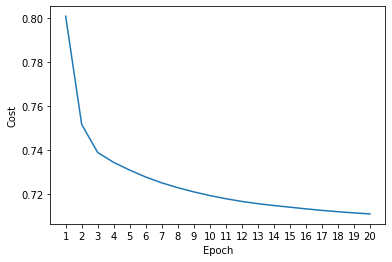

Accuracy after training on train data is: 35.5%
Accuracy after training on test data is: 28.499999999999996%


In [85]:
num_of_epochs = 20
batch_size = 16
learning_rate = 0.3

start = time.time()

X = data_train_gray[:200]
Y = label_train[:200]

W1_t,W2_t,W3_t,b1_t,b2_t,b3_t,costs = train_with_vectorization(X, Y, num_of_epochs, batch_size, learning_rate, 1024, 4, 16, 16)
end = time.time()
print(f"Runtime is {end - start} seconds")

mp.pyplot.plot(costs)
mp.pyplot.xticks(np.arange(len(costs)), np.arange(1, len(costs)+1))
mp.pyplot.xlabel("Epoch")
mp.pyplot.ylabel("Cost")
mp.pyplot.show()

accuracy = accuracy_calc(X, Y, W1_t, W2_t, W3_t, b1_t, b2_t, b3_t)
print('Accuracy after training on train data is: ' + str(accuracy) + "%")

X_test = data_test_gray[:200]
Y_test = label_test[:200]

accuracy = accuracy_calc(X_test, Y_test, W1_t, W2_t, W3_t, b1_t, b2_t, b3_t)
print('Accuracy after training on test data is: ' + str(accuracy) + "%")

**Check results for 10 times**

Given that the speed of our code execution has increased due to the matrix operations, for this section, we design our code in such a way that it runs 10 times from the beginning of the code and gives the final result as the average of the total output.

First of all we define two functions to plot the results of these executions.

In [98]:
'''
This function plots accuracy graph of train and test data after 10 time execution of vectorized backpropagation.
'''
def plot_10_accuracy(train_accuracy, test_accuracy):
    mp.pyplot.title("Test & Trial accuracy per trial")
    mp.pyplot.plot(train_accuracy, label='train accuracy')
    mp.pyplot.plot(test_accuracy, label='test accuracy')
    mp.pyplot.xticks(np.arange(len(test_accuracy)), np.arange(1, len(test_accuracy)+1))
    mp.pyplot.legend()
    mp.pyplot.xlabel("Number of trial")
    mp.pyplot.ylabel("Accuracy")
    
    # To calculate the mean accuracy test data, we sum the accuracies for 10 time
    # execution of vectorized backpropagation and then divide it by the number of
    # accuracies we have.
    mean_test_acc = sum(test_accuracy)/len(test_accuracy)
    message = f"Mean test accuracy for 10 trial is {mean_test_acc}"
    mp.pyplot.figtext(0.5, -0.05, message, wrap=True, horizontalalignment='center', fontsize=12)
    mp.pyplot.show()

'''
This function plots 10 cost-epoch graphs after execution of vectorized backpropagation.
It plots these graphs in two rows and five columns, each is for one trial.
'''
def plot_10_cost_per_trial(costs):
  fig, axs = mp.pyplot.subplots(2, 5, sharex=True, sharey=True, figsize=(15,8))
  fig.suptitle('Cost per epoch for 10 trials')
  # Plot first row
  for i in range(5):
    axs[0,i].plot(costs[i])
    axs[0,i].set_title('Trial ' + str(i))
    axs[0,i].set(xlabel = 'Epoch', ylabel = 'Cost')
    axs[0,i].set_xticks(np.arange(0, len(costs[i]), 4))
    axs[0,i].set_xticklabels(np.arange(1, len(costs[5+i])+1, 4))
  # Plot second row
  for i in range(5):
    axs[1,i].plot(costs[i+5])
    axs[1,i].set_title('Trial ' + str(i+5))
    axs[1,i].set(xlabel = 'Epoch', ylabel = 'Cost')
    axs[1,i].set_xticks(np.arange(0, len(costs[i]), 4))
    axs[1,i].set_xticklabels(np.arange(1, len(costs[5+i])+1, 4))


Runtime is 11.346304416656494 seconds


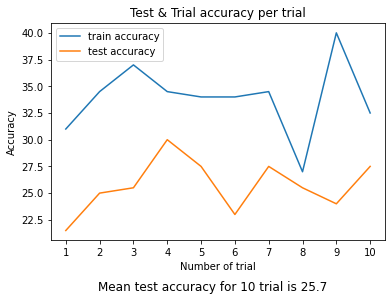

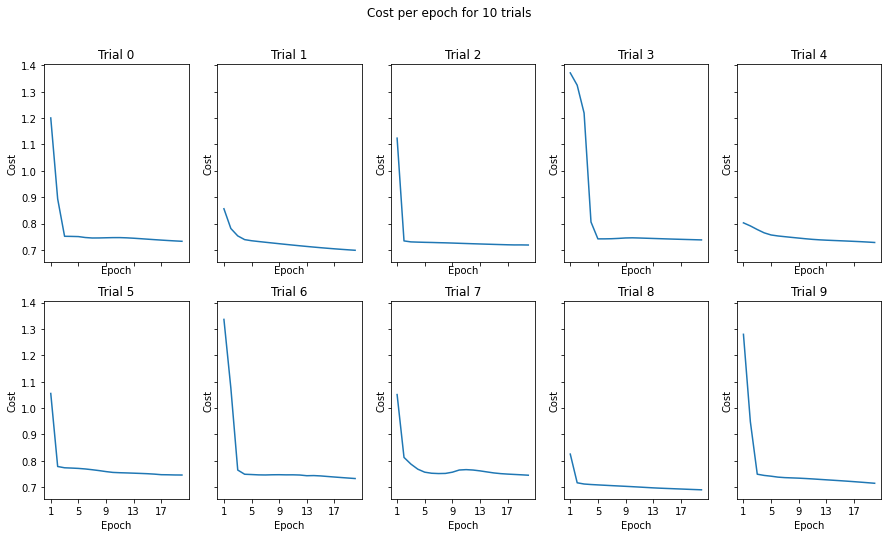

In [139]:
train_accuracy = []
test_accuracy = []
costs = []
num_of_epochs = 20

X = data_train_gray[:200]
Y = label_train[:200]

X_test = data_test_gray[:200]
Y_test = label_test[:200]

# We train 10 times, each time get weights and biases.
# Each time we store the obtained cost in an array.
# Then we calculate the accuracy with that variables for train and test sets.
start = time.time()
for temp in range(10):
  W1_t,W2_t,W3_t,b1_t,b2_t,b3_t,cost = train_with_vectorization(X, Y, num_of_epochs, batch_size, learning_rate, 1024, 4, 16, 16)
  train_acc = accuracy_calc(X, Y, W1_t, W2_t, W3_t, b1_t, b2_t, b3_t)
  test_acc = accuracy_calc(X_test, Y_test, W1_t, W2_t, W3_t, b1_t, b2_t, b3_t)
  train_accuracy.append(train_acc)
  test_accuracy.append(test_acc)
  costs.append(cost)
end = time.time()

print(f"Runtime is {end - start} seconds")

plot_10_accuracy(train_accuracy, test_accuracy)
plot_10_cost_per_trial(costs)

**Step 5: Testing the model**

Now that we have optimized the algorithm well, we can train on all 4 class data (8000 data in total). Set the size_batch value to 16, the learning factor to 0.3, and the number of epochs to 40.

Runtime is 91.04229664802551 seconds


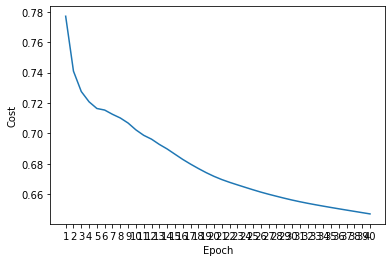

In [146]:
num_of_epochs = 40
batch_size = 16
learning_rate = 0.3

data_train_gray, label_train = shuffle_same_order(data_train_gray, label_train)
X = data_train_gray[:8000]
Y = label_train[:8000]

start = time.time()
W1_t,W2_t,W3_t,b1_t,b2_t,b3_t,cost = train_with_vectorization(X, Y, num_of_epochs, batch_size, learning_rate, 1024, 4, 16, 16)
end = time.time()
print(f"Runtime is {end - start} seconds")

mp.pyplot.plot(cost)
mp.pyplot.xticks(np.arange(len(cost)), np.arange(1, len(cost)+1))
mp.pyplot.xlabel("Epoch")
mp.pyplot.ylabel("Cost")
mp.pyplot.show()

In [147]:
# We calculate the accuracy for train and test datasets with obtained weights and biases
train_accuracy = accuracy_calc(X, Y, W1_t, W2_t, W3_t, b1_t, b2_t, b3_t)
print("accuracy for train data after training: " + str(train_accuracy) + " %")

data_test_gray, label_test = shuffle_same_order(data_test_gray, label_test)
X_test = data_test_gray[:8000]
Y_test = label_test[:8000]

test_accuracy= accuracy_calc(X_test, Y_test, W1_t, W2_t, W3_t, b1_t, b2_t, b3_t)
print("accuracy for test data after training: " + str(test_accuracy) + " %")

accuracy for train data after training: 47.175 %
accuracy for test data after training: 24.125 %


**Check results for 10 times**

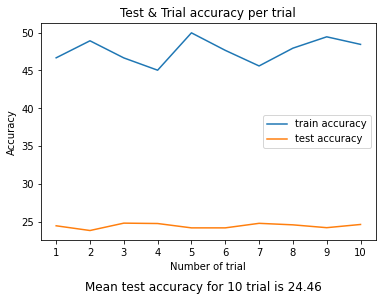

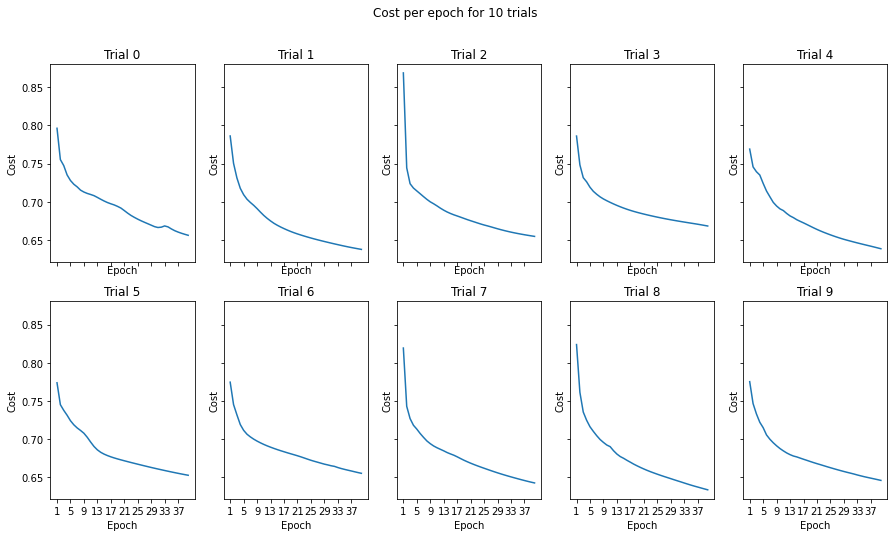

In [148]:
train_accuracy = []
test_accuracy = []
costs = []

X = data_train_gray[:8000]
Y = label_train[:8000]

X_test = data_test_gray[:8000]
Y_test = label_test[:8000]

# We train 10 times, each time get weights and biases.
# Each time we store the obtained cost in an array.
# Then we calculate the accuracy with that variables for train and test sets.
for temp in range(10):
  W1_t,W2_t,W3_t,b1_t,b2_t,b3_t,cost = train_with_vectorization(X, Y, num_of_epochs, batch_size, learning_rate, 1024, 4, 16, 16)
  train_acc = accuracy_calc(X, Y, W1_t, W2_t, W3_t, b1_t, b2_t, b3_t)
  test_acc = accuracy_calc(X_test, Y_test, W1_t, W2_t, W3_t, b1_t, b2_t, b3_t)
  train_accuracy.append(train_acc)
  test_accuracy.append(test_acc)
  costs.append(cost)

plot_10_accuracy(train_accuracy, test_accuracy)
plot_10_cost_per_trial(costs)